In a previous [article](https://codingdisciple.com/hypothesis-testing-welch-python.html) of this series, I talked about hypothesis testing and confidence intervals using classical methods. However, we had to make assumptions to justify our methods. So what if the distribution is not normal? What if our sample size is so small that we can't use the central limit theorem.

Modern statiscal methods uses raw computational power to create the distribution. We can then use this distribution to estimate the likelihood of an event. This is very useful for answering questions such as  “Is A better than B?” or “Did adding feature X improve our product?”. The statistical method I am going to focus on in this article is <b>bootstrapping</b>. The great thing about this method is we don't have to assume a normal distribution.


### Bootstrap Confidence Intervals for Facebook Data - 1 Group

The idea of bootstrapping is to take many samples with replacement from the observed data set to generate a bootstrap population. Then we can use the bootstrapped population to create a sampling distribution. 

For example, suppose that our data set looks something like this `[5, 2, 1, 10]`. Sampling with replacement can generate permutations such as: `[5, 5, 1, 10]` or `[2, 2, 2, 10]`. The idea is to take many permutations of this data set to create a bootstrap population.

In this article, we'll look into Facebook data once again to determine if a paid post gets more "likes" than an unpaid post. I've taken data from UCI's machine learning repository. Click [here](https://archive.ics.uci.edu/ml/datasets/Facebook+metrics) for the link to the documentation and citation.

#### Library imports and read in data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('dataset_Facebook.csv', delimiter=';')

#### Data exploration

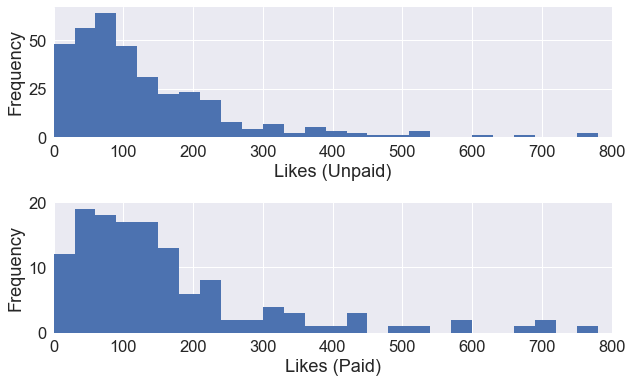

unpaid_mean: 155.84679665738162
paid_mean: 235.6474820143885


In [2]:
#Boolean filtering/remove missing values
unpaid_likes = data[data['Paid']==0]['like']
paid_likes = data[data['Paid']==1]['like']
paid_likes = paid_likes.dropna()
unpaid_likes = unpaid_likes.dropna()

#Figure settings
sns.set(font_scale=1.65)
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=.5)    

#Plot top histogram
ax = fig.add_subplot(2, 1, 1)
ax = unpaid_likes.hist(range=(0, 1500),bins=50)
ax.set_xlim(0,800)
plt.xlabel('Likes (Unpaid)')
plt.ylabel('Frequency')

#Plot bottom histogram
ax2 = fig.add_subplot(2, 1, 2)
ax2 = paid_likes.hist(range=(0, 1500),bins=50)
ax2.set_xlim(0,800)

plt.xlabel('Likes (Paid)')
plt.ylabel('Frequency')

plt.show()
print('unpaid_mean: {}'.format(unpaid_likes.mean()))
print('paid_mean: {}'.format(paid_likes.mean()))

In [3]:
print('paid_size: {}'.format(len(paid_likes)))
print('unpaid_size: {}'.format(len(unpaid_likes)))

paid_size: 139
unpaid_size: 359


#### The bootstrap process - 1 sample confidence interval

Let's start with the paid group, given a sample of 139 rows. We want to create a bootstrap population of 10,000 x 139. We can do this by using the resample function from scikit-learn.

In [4]:
from sklearn.utils import resample
resample(paid_likes).head()

213     11.0
51     285.0
166     77.0
367    138.0
149     24.0
Name: like, dtype: float64

In [5]:
resample(paid_likes).head()

378    152.0
269     47.0
475     65.0
202     53.0
232     14.0
Name: like, dtype: float64

In [6]:
resample(paid_likes).head()

83     101.0
476    579.0
348    155.0
169     99.0
104     59.0
Name: like, dtype: float64

Notice how every sample is different, we are simply just reshuffling the data set of 137 rows. Next, we'll use a for loop to generate 10000 permutations with replacement of the 137 rows. I used a random seed within the for loop for consistency, but it is not required. 

In [7]:
paid_bootstrap = []
for i in range(10000):
    np.random.seed(i)
    paid_bootstrap.append((resample(paid_likes)))
print(len(paid_bootstrap))

10000


Next, we'll calculate the mean of every permutation of the 137 rows. This will result in a numpy array with 10,000 sample means.

In [8]:
bootstrap_means = np.mean(paid_bootstrap, axis=1)
bootstrap_means

array([ 213.33093525,  222.88489209,  410.35251799, ...,  241.94964029,
        201.73381295,  196.22302158])

#### The 95% confidence interval

Finally, we can plot the histogram of the sample means to get our sampling distribution. If we want the 95% confidence interval, we simply cut off 2.5% of the tail on both sides of the distribution. This can be easily done with the `numpy.percentile()` function.

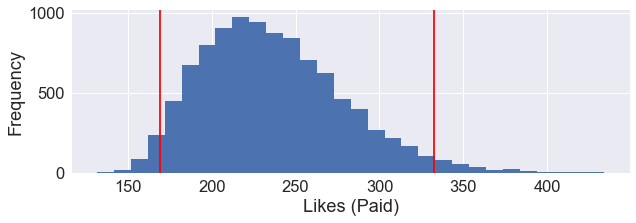

Lower bound: 168.80521582733815
Upper bound: 332.3535971223021


In [9]:
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

fig = plt.figure(figsize=(10,3))
ax = plt.hist(bootstrap_means, bins=30)

plt.xlabel('Likes (Paid)')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color='r')
plt.axvline(upper_bound, color='r')
plt.show()

print('Lower bound: {}'.format(lower_bound))
print('Upper bound: {}'.format(upper_bound))

The area within the boundaries of the red lines is our 95% confidence limit. In other words, if we take many samples  and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the true population mean.

Also, note that this distribution is slightly right skewed, so it doesn't fit fully fit the normal distribution assumption. So I would trust the confidence interval calculated via bootstrapping a lot more than the confidence interval calculated using classical methods.

#### Confidence intervals using seaborn

Seaborn plots also uses bootstrapping for calculating the confidence intervals. We just have to simply specify this parameter when plotting out our data.

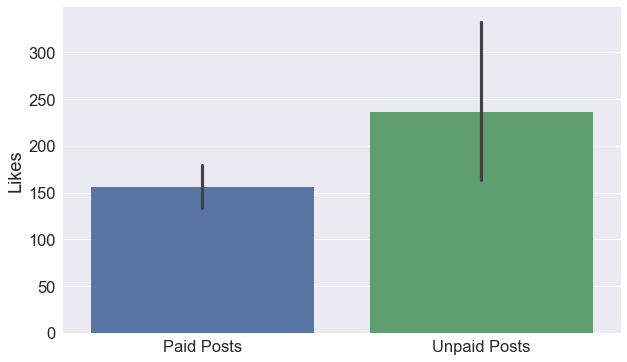

In [10]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Paid', y='like', data=data, ci=95)
x = ['Paid Posts', 'Unpaid Posts']

plt.xticks([0, 1],x)
plt.ylabel('Likes')
plt.xlabel('')
plt.show() 

### Bootstrap Confidence Intervals for Facebook Data - 2 Groups

We can perform the same process for the two sample case. We'll create 10,000 permutations with replacement on both the paid group and the unpaid group. Then we'll calculate the mean of each permutation.

In [11]:
paid_bootstrap = []
for i in range(10000):
    np.random.seed(i)
    paid_bootstrap.append((resample(paid_likes)))

paid_bootstrap = np.mean(paid_bootstrap, axis=1)
paid_bootstrap

array([ 213.33093525,  222.88489209,  410.35251799, ...,  241.94964029,
        201.73381295,  196.22302158])

In [12]:
unpaid_bootstrap = []
for i in range(10000):
    np.random.seed(i)
    unpaid_bootstrap.append((resample(unpaid_likes)))
    
unpaid_bootstrap = np.mean(unpaid_bootstrap, axis=1)
unpaid_bootstrap

array([ 152.06128134,  145.72980501,  136.53760446, ...,  151.36211699,
        170.83008357,  180.14206128])

We've just created 10,000 bootstrap samples means for both the paid group and the unpaid group. If we can take the difference between these means from the two groups. This will allow us to estimate the confidence interval for the true  difference in likes between paid and unpaid groups.

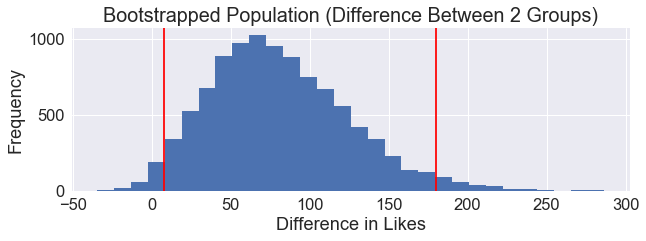

Lower bound: 7.5176243963046785
Upper bound: 179.7893358850524


In [13]:
differences = paid_bootstrap - unpaid_bootstrap
lower_bound = np.percentile(differences, 2.5)
upper_bound = np.percentile(differences, 97.5)

fig = plt.figure(figsize=(10,3))
ax = plt.hist(differences, bins=30)

plt.xlabel('Difference in Likes')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color='r')
plt.axvline(upper_bound, color='r')
plt.title('Bootstrapped Population (Difference Between 2 Groups)')
plt.show()

print('Lower bound: {}'.format(lower_bound))
print('Upper bound: {}'.format(upper_bound))

In [14]:
differences[differences <= 0].shape[0]

106

106 samples out of 10,000 were under or equal 0 assuming an increase did not happen. We are 95% confident that the true difference between paid groups and unpaid groups is between 7.52 and 179.79.


### Hypothesis testing - Paid vs. Unpaid Groups

We can also use bootstrapping for hypothesis testing. We want to know if paying for advertisements on Facebook will increase the amount of likes on the post. Our null hypothesis would suggest that paying for advertisements <b>does not</b> affect the amount of likes.

$ H_0:μ_1 - μ_0 = 0 $

The alternative hypothesis would suggest that paying for advertisements <b>does</b> increase the amount of likes.

$ H_a: μ_1 - μ_0 > 0 $

When it comes to hypothesis testing, we always start by assuming that the null hypothesis is true. The idea is to simulate a very large bootstrapped population of data and then drawing the samples from this bootstrapped population. Then we'll check the likelihood of getting observed difference in means. If the likelihood is less than 0.05, we'll reject the null hypothesis.

The code below generates 10,000 samples of length 139 and 10,000 samples of length 359 from the combined data and then calculate the difference in sample means.

In [15]:
combined = np.concatenate((paid_likes, unpaid_likes), axis=0)

perms_paid = []
perms_unpaid = []

for i in range(10000):
    np.random.seed(i)
    perms_paid.append(resample(combined, n_samples = len(paid_likes)))
    perms_unpaid.append(resample(combined, n_samples = len(unpaid_likes)))
    
dif_bootstrap_means = (np.mean(perms_paid, axis=1)-np.mean(perms_unpaid, axis=1))
dif_bootstrap_means

array([-17.03639206,  -2.20771127,  -1.03336606, ...,  27.32095549,
        24.98577183,  18.7842929 ])

The histogram below is the distribution of differences in sample means from our bootstrapped population.

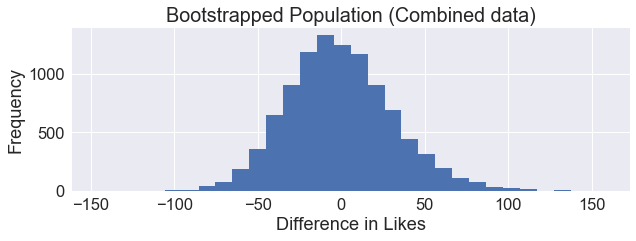

In [16]:
fig = plt.figure(figsize=(10,3))
ax = plt.hist(dif_bootstrap_means, bins=30)

plt.xlabel('Difference in Likes')
plt.ylabel('Frequency')
plt.title('Bootstrapped Population (Combined data)')
plt.show()

Next, let's calculate the observed difference in means from our actual data.

In [17]:
obs_difs = (np.mean(paid_likes) - np.mean(unpaid_likes))
print('observed difference in means: {}'.format(obs_difs))

observed difference in means: 79.80068535700687


Using our bootstrapped distribution and the observed difference, we can determine the likelihood of getting a difference in means of 79.80.

In [18]:
p_value = dif_bootstrap_means[dif_bootstrap_means >= obs_difs].shape[0]/10000
print('p-value: {}'.format(p_value))

p-value: 0.0137


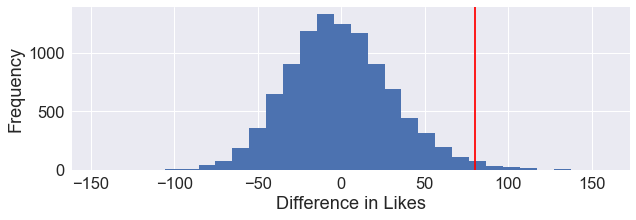

In [19]:
fig = plt.figure(figsize=(10,3))
ax = plt.hist(dif_bootstrap_means, bins=30)

plt.xlabel('Difference in Likes')
plt.ylabel('Frequency')
plt.axvline(obs_difs, color='r')
plt.show()

Out of 10,000 bootstrap samples, only 137 of these samples had a difference in means of 79.8 or higher shown by the red line above. Resulting in a p-value of 0.0137. This is not a very likely occurence. As a result, we will reject the null hypothesis.

---

The files used for this article can be found in my [GitHub repository](https://github.com/sengkchu/codingdisciple.content/tree/master/Learning%20data%20science/Learning/Studying%20Statistics/Nonparametric%20Methods%20-%20Bootstrap%20Confidence%20Intervals%20and%20Permutation%20Hypothesis%20Testing).